In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from matminer.utils.conversions import str_to_composition
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.composition import ElementFraction
#from matminer.featurizers.structure import DensityFeatures
#DensityFeatures doesn't work because it depends on an old version of pymatgen
#the newest version of pymatgen doesn't have the module 'pymatgen.analysis.defects.point_defects' which DensityFeatures needs to import sucessfully

In [2]:
df  = pd.read_pickle('../deliver/NIST_CeramicDataSet.pkl')
df.head()

,chemicalFormula,licenses,names,preparation,references,Axis Length,Axis Length-conditions,Axis Length-units,Bulk Modulus,Bulk Modulus-conditions,...,Thermal Expansion-conditions,Thermal Expansion-units,Thermal Shock Resistance,Thermal Shock Resistance-conditions,Thermal Shock Resistance-units,Weibull Modulus,Weibull Modulus-conditions,Weibull Strength,Weibull Strength-conditions,Weibull Strength-units
1,SiO2,[{'name': 'NIST_SRD-30'}],[Silica],NaN,"[{'citation': 'Gaseous Corrosion of Ceramics, ...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3Al2O3.2SiO2.xZrO2.yY2O3,[{'name': 'NIST_SRD-30'}],[Mullite composite],[{'name': 'Hot Pressing'}],[{'citation': 'Thermal Diffusivity/Conductivit...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Al2O3,[{'name': 'NIST_SRD-30'}],[Alumina],[{'name': 'Hot Pressing'}],"[{'citation': 'Mechanical Properties of Pure, ...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Si3N4.xCeO2.ySiC,[{'name': 'NIST_SRD-30'}],[Silicon nitride composite],[{'name': 'Hot Pressing'}],[{'citation': 'Effect of Silicon Carbide Whisk...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Si3N4,[{'name': 'NIST_SRD-30'}],[Silicon nitride],[{'name': 'Hot Isostatic Pressing'}],[{'citation': 'Corrosion of Silicon Nitride Ce...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Composition with Chih-Hao's method

In [3]:
df1 = df.copy()
df1.loc[3892,'chemicalFormula'] = 'BN' #fix 'B-N' to 'BN'

In [4]:
# Parse the chemicalFormula
def formula_decompose(formula):
    '''
    decompose chemical formula 
    return
        composition: list, [(element,num),...]
            element: string
            num: string, can be math expression such as '1+0.5x'
    '''

    comp = []
    p = re.compile(r'(\d?[w-z]?)([A-Z][a-u]?)(\d*\+?\-?\d*\.?\d*[w-z]?)')

    #split the chemical formula if there is dots, but not for cases like Mg1.5x
    if re.search(r'\.', formula) and not re.search(r'\d+\.\d[w-z]', formula): 
        formula = formula.split('.')
        for item in formula:
            prefactor = '1'
            for i in re.findall(p, item):
                pre, elem, num = i
                if pre:
                    prefactor = pre
                if num == '':
                    num = '1'
                num = prefactor + '*({})'.format(num)
                comp.append((elem, num))
    else:
        prefactor = '1'
        for i in re.findall(p, formula):
            pre, elem, num = i
            if pre:
                prefactor = pre
            if num == '':
                num = '1'
            num = prefactor + '*({})'.format(num)
            comp.append((elem, num))
    return comp 

def formula_reconstruct(composition, x=0.1, y=0.1, z=0.1, w=0.1):
    '''
    reconstruct chemical formula from composition
    composition in form of [(element,num), (element,num),...]
        element: string
        num: string, can be math expression such as '1+0.5x'

    return 
        flat chemcial formula: string, such as 'Ti1.5Cu0.1Au1.0'
    '''
    flat_list = []
    for (elem, num) in composition:
        num = re.sub(r'(\d)([w-z])', r'\1*\2', num) #convert 5x to 5*x
        flat_list.append(elem)
        flat_list.append(format(eval(num), '.1f'))
    return ''.join(flat_list)
  
def formula_parser(formula):
    return formula_reconstruct(formula_decompose(formula))

In [5]:
df1["flatFormula"] = df1["chemicalFormula"].map(formula_parser)
df1.dropna(axis=1).head()

,chemicalFormula,licenses,references,Chemical Family,flatFormula
1,SiO2,[{'name': 'NIST_SRD-30'}],"[{'citation': 'Gaseous Corrosion of Ceramics, ...",Si-O,Si1.0O2.0
2,3Al2O3.2SiO2.xZrO2.yY2O3,[{'name': 'NIST_SRD-30'}],[{'citation': 'Thermal Diffusivity/Conductivit...,Al-Si-O:ZrO,Al6.0O9.0Si2.0O4.0Zr0.1O0.2Y0.2O0.3
3,Al2O3,[{'name': 'NIST_SRD-30'}],"[{'citation': 'Mechanical Properties of Pure, ...",Al-O,Al2.0O3.0
4,Si3N4.xCeO2.ySiC,[{'name': 'NIST_SRD-30'}],[{'citation': 'Effect of Silicon Carbide Whisk...,Si-N:CeO,Si3.0N4.0Ce0.1O0.2Si0.1C0.1
5,Si3N4,[{'name': 'NIST_SRD-30'}],[{'citation': 'Corrosion of Silicon Nitride Ce...,Si-N,Si3.0N4.0


In [6]:
df1["composition"] =df1["flatFormula"].transform(str_to_composition)
df1.dropna(axis=1).head()

,chemicalFormula,licenses,references,Chemical Family,flatFormula,composition
1,SiO2,[{'name': 'NIST_SRD-30'}],"[{'citation': 'Gaseous Corrosion of Ceramics, ...",Si-O,Si1.0O2.0,"(Si, O)"
2,3Al2O3.2SiO2.xZrO2.yY2O3,[{'name': 'NIST_SRD-30'}],[{'citation': 'Thermal Diffusivity/Conductivit...,Al-Si-O:ZrO,Al6.0O9.0Si2.0O4.0Zr0.1O0.2Y0.2O0.3,"(Al, O, Si, Zr, Y)"
3,Al2O3,[{'name': 'NIST_SRD-30'}],"[{'citation': 'Mechanical Properties of Pure, ...",Al-O,Al2.0O3.0,"(Al, O)"
4,Si3N4.xCeO2.ySiC,[{'name': 'NIST_SRD-30'}],[{'citation': 'Effect of Silicon Carbide Whisk...,Si-N:CeO,Si3.0N4.0Ce0.1O0.2Si0.1C0.1,"(Si, N, Ce, O, C)"
5,Si3N4,[{'name': 'NIST_SRD-30'}],[{'citation': 'Corrosion of Silicon Nitride Ce...,Si-N,Si3.0N4.0,"(Si, N)"


### Drop samples without 'density'

In [7]:
# New DataFrame containing only samples with a density value
df_dens = df1[df1.isnull()['Density'] == False]

In [8]:
df_dens.shape

(398, 163)

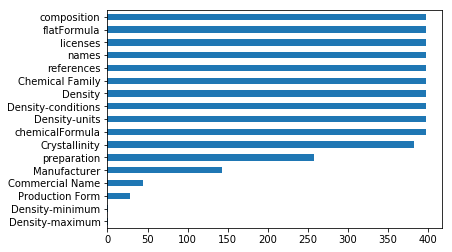

In [9]:
# Plot occurrence of features of the reduced dataset
df_dens.count().sort_values()[-17:].plot.barh()
plt.show()

In [10]:
# Drop all columns that contain less than 300 entries 
# (crystallinity is only features left with NaN)
df_dens = df_dens.dropna(axis=1, thresh=300)

### Clean up columns

In [11]:
df_dens.head()

,chemicalFormula,licenses,names,references,Chemical Family,Crystallinity,Density,Density-conditions,Density-units,flatFormula,composition
14,Si12-4.5xAl4.5xO1.5xN16-1.5xDyx,[{'name': 'NIST_SRD-30'}],[Sialon composite],[{'citation': 'Preparation and Properties of S...,Si-Al-O-N:Dy,Polycrystalline,3.30,"[{'name': 'x of Dyx', 'scalars': [{'value': '0...",g cm$^{-3}$,Si11.6Al0.5O0.2N15.8D0.1,"(Si, Al, O, N, D0+)"
19,NiO,[{'name': 'NIST_SRD-30'}],[Nickel oxide],"[{'citation': 'Thermal Constants for Ni, NiO, ...",Ni-O,Single Crystal,6.80,"[{'name': 'Massof Specimen', 'scalars': [{'val...",g cm$^{-3}$,Ni1.0O1.0,"(Ni, O)"
23,ZrO2,[{'name': 'NIST_SRD-30'}],[Zirconia (TZP)],[{'citation': 'Effects of Environment on the M...,Zr-O:Al,Polycrystalline,5.4,"[{'name': 'Temperature', 'scalars': [{'value':...",g cm$^{-3}$,Zr1.0O2.0,"(Zr, O)"
35,WC.xCo,[{'name': 'NIST_SRD-30'}],[Tungsten carbide],[{'citation': 'Engineering Properties of Carbi...,W-C,Polycrystalline,15.3,"[{'name': 'Temperature', 'scalars': [{'value':...",g cm$^{-3}$,W1.0C1.0Co0.1,"(W, C, Co)"
46,Si3N4,[{'name': 'NIST_SRD-30'}],[Silicon nitride],[{'citation': 'Corrosion of Silicon Nitride Ce...,Si-N,Polycrystalline,3.23,"[{'name': 'Sample Number', 'scalars': [{'value...",g cm$^{-3}$,Si3.0N4.0,"(Si, N)"


We can drop some more columns that don't contain numerical or categorical data. Further, we 

In [12]:
# Check if all density units are the same, in which case we don't need the units.
df_dens['Density-units'].unique()

array(['g cm$^{-3}$'], dtype=object)

In [13]:
# Determine number of polycrystalline / single crystal samples
N_polyX = df_dens[df_dens['Crystallinity']=='Polycrystalline']['Crystallinity'].shape
N_singleX = df_dens[df_dens['Crystallinity']=='Single Crystal']['Crystallinity'].shape
print('Polycrystalline: {0}, Single crystal: {1}'.format(N_polyX, N_singleX))

Polycrystalline: (354,), Single crystal: (27,)


In [14]:
#Fill NaN values in crystallinity with polycrystalline:
df_dens['Crystallinity'] = df_dens['Crystallinity'].fillna('Polycrystalline')

In [15]:
# Check how density values cannot simply be transformed from string to int

N_errors, N_total = 0, 0
for entry in df_dens['Density']:
    try:
        pd.Series([entry]).astype(float)
    except:
        N_errors +=1
        print(entry)
    finally:
        N_total +=1

print('{0} errors in {1} samples'.format(N_errors, N_total))





3.16 (1%)
1 errors in 398 samples


## Convert a column of dataframe (e.g. Density) to float values from strings

In [16]:
df_dens.shape

(398, 11)

In [17]:
df_d = df_dens.drop(['licenses','names','references','Density-units','Density-conditions','Chemical Family'], axis=1)
df_d.head()

,chemicalFormula,Crystallinity,Density,flatFormula,composition
14,Si12-4.5xAl4.5xO1.5xN16-1.5xDyx,Polycrystalline,3.30,Si11.6Al0.5O0.2N15.8D0.1,"(Si, Al, O, N, D0+)"
19,NiO,Single Crystal,6.80,Ni1.0O1.0,"(Ni, O)"
23,ZrO2,Polycrystalline,5.4,Zr1.0O2.0,"(Zr, O)"
35,WC.xCo,Polycrystalline,15.3,W1.0C1.0Co0.1,"(W, C, Co)"
46,Si3N4,Polycrystalline,3.23,Si3.0N4.0,"(Si, N)"


In [18]:
# Check how density values cannot simply be transformed from string to int
#also locate which row the errors occur in

N_errors, N_total, row = 0, 0, -1
for entry in df_d['Density']:
    row+=1
    try:
        pd.Series([entry]).astype(float)
    except:
        N_errors +=1
        print(entry)
        print(row)
        
    finally:
        N_total +=1

print('{0} errors in {1} samples'.format(N_errors, N_total))


3.16 (1%)
109
1 errors in 398 samples


In [19]:
#examine the troublesome density value in the 109th row of df_d
df_d.iloc[109]


chemicalFormula                SiC
Crystallinity      Polycrystalline
Density                  3.16 (1%)
flatFormula              Si1.0C1.0
composition                (Si, C)
Name: 1185, dtype: object

In [20]:
#convert the troublesome density value to a good value
df_d.set_value(1185, 'Density', '3.16');
df_d.loc[1185]


chemicalFormula                SiC
Crystallinity      Polycrystalline
Density                       3.16
flatFormula              Si1.0C1.0
composition                (Si, C)
Name: 1185, dtype: object

In [21]:
df_d['index1'] = df_d.index
df_d.head()

,chemicalFormula,Crystallinity,Density,flatFormula,composition,index1
14,Si12-4.5xAl4.5xO1.5xN16-1.5xDyx,Polycrystalline,3.30,Si11.6Al0.5O0.2N15.8D0.1,"(Si, Al, O, N, D0+)",14
19,NiO,Single Crystal,6.80,Ni1.0O1.0,"(Ni, O)",19
23,ZrO2,Polycrystalline,5.4,Zr1.0O2.0,"(Zr, O)",23
35,WC.xCo,Polycrystalline,15.3,W1.0C1.0Co0.1,"(W, C, Co)",35
46,Si3N4,Polycrystalline,3.23,Si3.0N4.0,"(Si, N)",46


In [22]:
#convert densities to floats
#df_d['Density'].astype(float)

N_errors, N_total, row = 0, 0, -1
for entry in df_d['index1']:
    row+=1
    try:
        dens_float = float(df_d.loc[entry]['Density'])
        df_d.set_value(entry, 'Density', dens_float)
    except:
        N_errors +=1
        print(entry)
        print(row)
        
    finally:
        N_total +=1

print('{0} errors in {1} samples'.format(N_errors, N_total))


0 errors in 398 samples


In [23]:
#sort by density
#it actually sorts in numerical order because the density column contains floats, not strings

df_d.sort_values(by='Density')

,chemicalFormula,Crystallinity,Density,flatFormula,composition,index1
822,Al2O3,Polycrystalline,1.28,Al2.0O3.0,"(Al, O)",822
2550,B4C,Polycrystalline,1.29,B4.0C1.0,"(B, C)",2550
1903,AlN.xSiO2.yY2O3,Polycrystalline,1.72,Al1.0N1.0Si0.1O0.2Y0.2O0.3,"(Al, N, Si, O, Y)",1903
867,AlN,Polycrystalline,1.99,Al1.0N1.0,"(Al, N)",867
415,AlN,Polycrystalline,2.16,Al1.0N1.0,"(Al, N)",415
1363,BN.xAlN.yCaC2,Polycrystalline,2.2,B1.0N1.0Al0.1N0.1Ca0.1C0.2,"(B, N, Al, Ca, C)",1363
3149,SiO2,Noncrystalline,2.203,Si1.0O2.0,"(Si, O)",3149
1008,SiO2,Polycrystalline,2.203,Si1.0O2.0,"(Si, O)",1008
121,Si3N4.xY2O3,Polycrystalline,2.28,Si3.0N4.0Y0.2O0.3,"(Si, N, Y, O)",121
2535,B4C.xAl,Polycrystalline,2.28,B4.0C1.0Al0.1,"(B, C, Al)",2535


## Add features with element fraction

In [24]:

df_d_feat = df_d.copy()
ep_frac = ElementFraction()
df_d_feat = ep_frac.featurize_dataframe(df_d_feat, col_id = "composition", ignore_errors = True)

In [25]:
df_d_feat.shape

(398, 109)

In [26]:
list(set(df_d_feat.columns))

['Ne',
 'V',
 'Mn',
 'Ge',
 'Tb',
 'Pb',
 'Pu',
 'Np',
 'B',
 'Tm',
 'N',
 'Ba',
 'Fm',
 'Hf',
 'Rh',
 'Dy',
 'Pa',
 'Os',
 'Lr',
 'flatFormula',
 'U',
 'composition',
 'Ta',
 'Tc',
 'Re',
 'chemicalFormula',
 'Br',
 'No',
 'Es',
 'Pm',
 'Ru',
 'He',
 'Cl',
 'Ac',
 'Cf',
 'As',
 'Mo',
 'Ar',
 'Pd',
 'Nd',
 'O',
 'Zn',
 'Md',
 'Li',
 'Cd',
 'P',
 'Sc',
 'Lu',
 'Ag',
 'Mg',
 'I',
 'Kr',
 'Se',
 'Sr',
 'Zr',
 'Ca',
 'Xe',
 'Rn',
 'S',
 'Ga',
 'K',
 'Y',
 'Ho',
 'Hg',
 'Nb',
 'Th',
 'Te',
 'In',
 'Crystallinity',
 'Sn',
 'C',
 'Rb',
 'Pr',
 'H',
 'Po',
 'Tl',
 'Sm',
 'W',
 'Ni',
 'Ra',
 'Bk',
 'Er',
 'Gd',
 'Al',
 'Cs',
 'Pt',
 'At',
 'Cr',
 'Co',
 'Ir',
 'Cu',
 'Si',
 'Sb',
 'F',
 'Fr',
 'Ti',
 'Au',
 'Be',
 'Yb',
 'Density',
 'La',
 'index1',
 'Cm',
 'Ce',
 'Am',
 'Eu',
 'Na',
 'Bi',
 'Fe']

In [27]:
#we see that it creates a column for each element and the value of the column is the percentage of atoms in the composition of that element
df_d_feat.head()

,chemicalFormula,Crystallinity,Density,flatFormula,composition,index1,H,He,Li,Be,...,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr
14,Si12-4.5xAl4.5xO1.5xN16-1.5xDyx,Polycrystalline,3.3,Si11.6Al0.5O0.2N15.8D0.1,"(Si, Al, O, N, D0+)",14,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,NiO,Single Crystal,6.8,Ni1.0O1.0,"(Ni, O)",19,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,ZrO2,Polycrystalline,5.4,Zr1.0O2.0,"(Zr, O)",23,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,WC.xCo,Polycrystalline,15.3,W1.0C1.0Co0.1,"(W, C, Co)",35,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,Si3N4,Polycrystalline,3.23,Si3.0N4.0,"(Si, N)",46,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
#how many entires had an error? 398-395 = 3 errors
df_d_feat.dropna().shape

(395, 109)

In [29]:
df_d_feat.dropna().head()

,chemicalFormula,Crystallinity,Density,flatFormula,composition,index1,H,He,Li,Be,...,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr
19,NiO,Single Crystal,6.8,Ni1.0O1.0,"(Ni, O)",19,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,ZrO2,Polycrystalline,5.4,Zr1.0O2.0,"(Zr, O)",23,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,WC.xCo,Polycrystalline,15.3,W1.0C1.0Co0.1,"(W, C, Co)",35,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,Si3N4,Polycrystalline,3.23,Si3.0N4.0,"(Si, N)",46,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,HfB2,Polycrystalline,10.578,Hf1.0B2.0,"(Hf, B)",84,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
#examine the Si column since a good number of entries contain Si. 
df_d_feat['Si']

14           NaN
19      0.000000
23      0.000000
35      0.000000
46      0.428571
84      0.000000
101     0.373494
102     0.000000
117     0.421429
121     0.400000
128     0.000000
137     0.428571
162     0.416667
178     0.000000
210     0.000000
216     0.375000
224     0.000000
231     0.375000
267     0.375000
270     0.382716
271     0.000000
276     0.000000
280     0.000000
289     0.428571
293     0.000000
296     0.421429
301     0.500000
306     0.000000
307     0.387500
320     0.500000
          ...   
3812    0.398649
3814    0.000000
3821    0.000000
3832    0.428571
3865    0.360465
3894    0.000000
3902    0.000000
3905    0.000000
3917    0.000000
3926    0.000000
3937    0.500000
3950    0.421429
3959    0.397436
3964         NaN
3978    0.397436
3990    0.095238
3992    0.000000
3995    0.434783
3998    0.068966
4019    0.000000
4048    0.116071
4049    0.387500
4059    0.428571
4068    0.000000
4076    0.400000
4078    0.000000
4079    0.500000
4083    0.5000

### Add Additional Features with matminer

In [ ]:
df_dens.shape

In [ ]:
df_dens_add = df_dens.copy()

In [ ]:
# Add features with matminer
ep_feat = ElementProperty.from_preset(preset_name="magpie")
df_dens_add = ep_feat.featurize_dataframe(df_dens_add, col_id="composition", ignore_errors=True)

In [ ]:
df_dens_add.shape

In [ ]:
# List of the new columns
list(set(df_dens_add.columns) ^ set(df_dens.columns))

In [ ]:
df_dens_add['avg_dev Column'].head()

### Which features are numerical?

In [ ]:
df1_feat.dtypes[df1_feat.dtypes!='float64']

In [ ]:
# Exploring a non-scalar feature
df1_feat[['Thermal Expansion','Thermal Expansion-conditions','Thermal Expansion-units']].dropna()

In [ ]:
df1_feat.loc[89,'Thermal Expansion-conditions']

In [ ]:
df1_feat.loc[89,'chemicalFormula']

In [ ]:
df1_feat['Compressive Strength-minimum'].dropna()

In [ ]:
df.count().hist(bins=1000)
plt.xlim(0,100)
plt.show()

In [ ]:
plt.figure(figsize=(8,16))
df.count().sort_values()[-50:-8].plot.barh()
plt.show()